In [2]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


In [3]:
device = ("cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu")

print(f"Using {device} device")


Using cuda device


In [4]:
#%run -n dynamics_learning.ipynb
# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [5]:
class ResNet(MLP):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x) + x
        return logits

In [18]:
model = MLP().to(device) #ResNet().to(device)
exp_name = 'near90deg/'
model.load_state_dict(torch.load('../models/'+'pendulum_trained_near90deg.pth'))

<All keys matched successfully>

In [19]:
data = pd.read_csv('../data/pendulum_exps/'+exp_name+'testdata.csv')
#data = pd.read_csv('../data/pendulum_exps/pendulum_testdata.csv')

# Extract input features (X) and target labels (y)
X = data[['Pendulum Angle (rad)', 'Angular Velocity (rad/s)']].values  # Input features
y = data[['Pendulum Angle next (rad)', 'Angular Velocity next (rad/s)']].values  # Target labels
target_array = y
n_samples = X.shape[0]
print('n_samples=',n_samples)
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

test_dataset = TensorDataset(X_tensor, y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


n_samples= 9999


In [20]:
# Evaluation
model.eval()
test_loss = 0.0
criterion = nn.MSELoss()

outputs_array = np.zeros((n_samples,2))

with torch.no_grad():
    for batch, (inputs, targets) in enumerate(test_dataloader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outs_np = outputs.cpu().detach().numpy()
        outputs_size = outs_np.shape[0]
        outputs_array[batch*outputs_size:(batch+1)*outputs_size,:] = outs_np
        
        test_loss += criterion(outputs.squeeze(), targets).item()
        
test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0000


In [21]:
# Evaluation using recursive predictions. 
model.eval()

dt = 0.01
t_span = n_samples*dt
t_steps = n_samples # int(t_span/dt) #+1 to include time step =0
seq_outputs_array = np.zeros((t_steps,2))
seq_outputs_array[0,:] = target_array[0,:] #set initial condition.
test_loss = 0.0
with torch.no_grad():
    for i in range(t_steps-1):
        
        input = torch.tensor(seq_outputs_array[i,:], dtype=torch.float32).view(1,seq_outputs_array.shape[1])
        target = torch.tensor(target_array[i+1,:], dtype=torch.float32).view(1,target_array.shape[1])
        #print('predicted:', seq_outputs_array[i,:], 'truth:',target_array[i,:])
        
        input, target = input.to(device), target.to(device)
        
        output = model(input)

        out_np = output.cpu().detach().numpy()
        seq_outputs_array[i+1,:] = out_np
        #print(f'Output of network = {output}; target = {target}')
        test_loss += criterion(output.squeeze(), target.squeeze()).item()
        #print(f'Test loss = {test_loss}')
        
test_loss /= t_steps
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.5361


9999
(9999, 2)


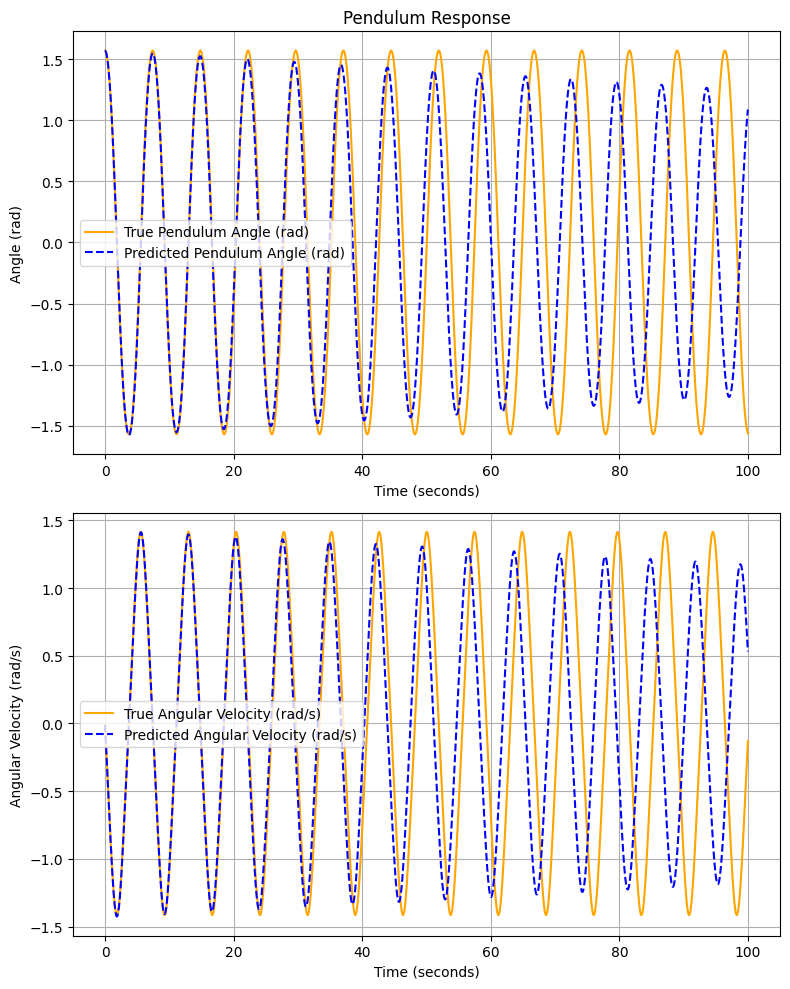

In [16]:

import matplotlib.pyplot as plt

t = np.linspace(0,t_span,t_steps)
print(len(t))
print(target_array.shape)
# Create subplots for angle and angular velocity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot pendulum angle
ax1.plot(t, target_array[0:t_steps, 0], label='True Pendulum Angle (rad)', color='orange')
ax1.plot(t, seq_outputs_array[0:t_steps, 0], '--', label='Predicted Pendulum Angle (rad)',color='blue')

ax1.set_title('Pendulum Response')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)
ax1.legend()

# Plot angular velocity
ax2.plot(t, target_array[0:t_steps, 1], label='True Angular Velocity (rad/s)', color='orange')
ax2.plot(t, seq_outputs_array[0:t_steps, 1], '--',label='Predicted Angular Velocity (rad/s)', color='blue')

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Angular Velocity (rad/s)')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
fig.savefig('../results/pendulum_exps/'+exp_name+'/simplenn_seq_prediction.png', bbox_inches='tight')

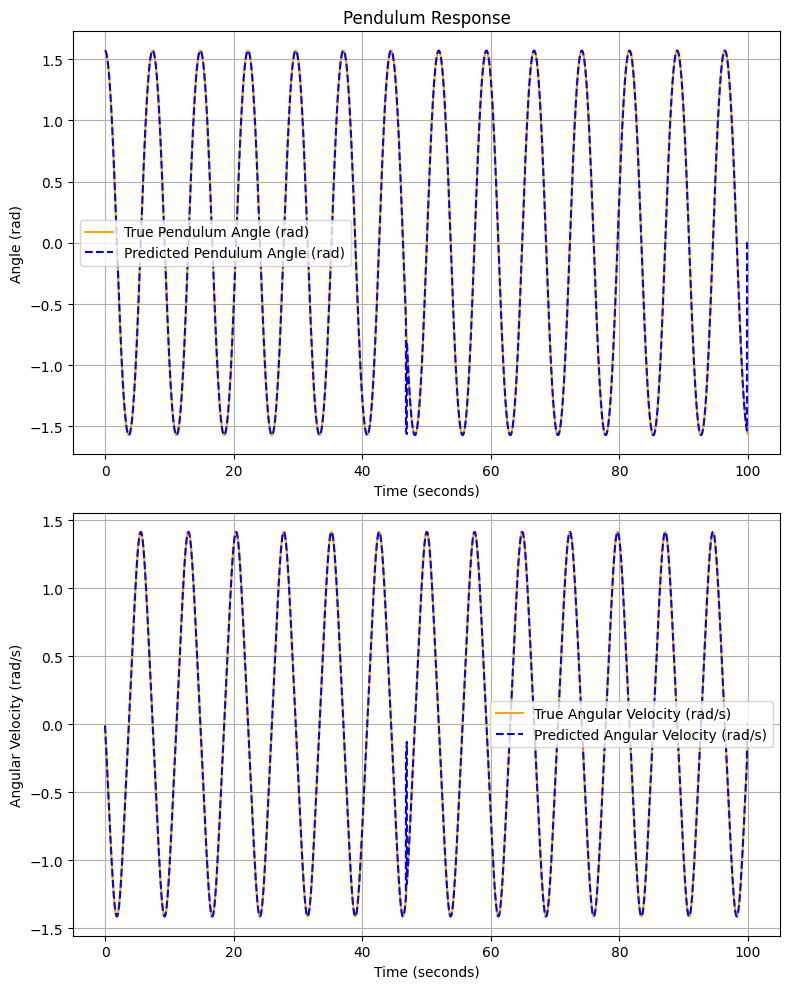

In [17]:

import matplotlib.pyplot as plt
t = np.linspace(0,n_samples*0.01,n_samples)
# Create subplots for angle and angular velocity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot pendulum angle
ax1.plot(t, target_array[:, 0], label='True Pendulum Angle (rad)', color='orange')
ax1.plot(t, outputs_array[:, 0], '--', label='Predicted Pendulum Angle (rad)',color='blue')

ax1.set_title('Pendulum Response')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)
ax1.legend()

# Plot angular velocity
ax2.plot(t, target_array[:, 1], label='True Angular Velocity (rad/s)', color='orange')
ax2.plot(t, outputs_array[:, 1], '--',label='Predicted Angular Velocity (rad/s)', color='blue')

ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Angular Velocity (rad/s)')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
fig.savefig('../results/pendulum_exps/'+exp_name+'/simplenn_1step_prediction.png', bbox_inches='tight')